In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Part 1 - Exploratory data analysis

In [6]:
data = json.load(open('logins.json')) 

In [9]:
df = pd.DataFrame.from_dict(data)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null object
dtypes: object(1)
memory usage: 727.8+ KB


In [15]:
df.login_time = pd.to_datetime(df.login_time, format='%Y-%m-%dT%H:%M:%S.%f')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [20]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [44]:
bins = df.groupby(pd.Grouper(key='login_time', freq='15T')).login_time.count()

In [59]:
df_group = pd.DataFrame.from_dict({'login_time': bins.index, 'n_times': bins})

In [77]:
df_group['time'] = df_group['login_time'].apply(pd.Timestamp.time)

In [79]:
df_group.head()

,login_time,n_times,time
login_time,,,
1970-01-01 20:00:00,1970-01-01 20:00:00,2,20:00:00
1970-01-01 20:15:00,1970-01-01 20:15:00,6,20:15:00
1970-01-01 20:30:00,1970-01-01 20:30:00,9,20:30:00
1970-01-01 20:45:00,1970-01-01 20:45:00,7,20:45:00
1970-01-01 21:00:00,1970-01-01 21:00:00,1,21:00:00


In [83]:
df_15min = df_group.groupby(df_group.time).n_times.sum()

In [97]:
ticks = ['00:00:00', '04:00:00', '08:00:00', '12:00:00', '16:00:00', '20:00:00', '23:59:59']

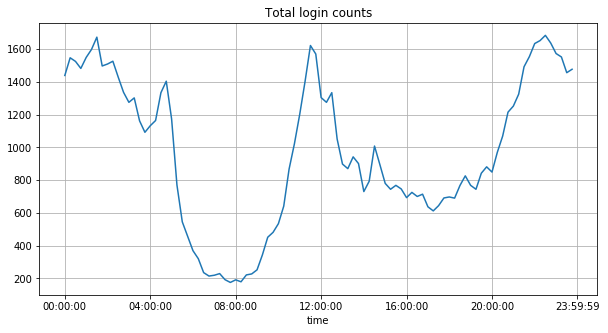

In [100]:
# Daily cycle of demand
df_15min.plot(title='Total login counts', grid=True, figsize=(10,5), xticks=ticks)
plt.show()

There are two demand peaks on daily cycles. One is around noon time, and the other is from about 10pm till 2am. It quiets down a little bit till about 4am, followed by a third smaller peak at about 5am.
The low demand time is about 6:30 am to 9 am, and another low demand time is about 5 pm to 7 pm.

In [105]:
df_group['day'] = df_group['login_time'].dt.dayofweek

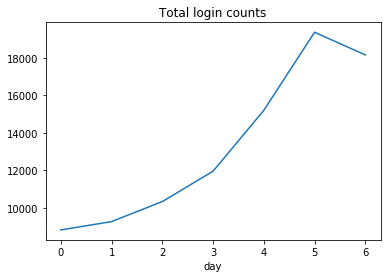

In [108]:
# Weekly cycle of demand
df_day = df_group.groupby(df_group.day).n_times.sum()
df_day.plot(title='Total login counts')

The demand peak in a week is Friday, followed by Saturday, Thursday, Wednesday, Tuesday, Monday and Sunday (lowest).

##  Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

My answer:
1. I would choose the average trips made between the two cities for a driver during the text period as the key measure of success of this experiment. Because if the hypothesis that the toll bridge has hindered some drivers to go to the other city is true, the average inter-city trips would increase significantly when the toll costs can be reimbursed.

2. I will design an A/B test kind of experiment to decide the effectiveness of the toll reimbursement proposal.

a. I will randomly select half of the driver partners to implement the toll reimbursement policy (Test Group B), and the other half of the drivers would not receive this benefit (Control Group A). At the end of the test period, I will collect the inter-city trips for each driver in both groups after the policy takes effective and calculate the mean and standard deviation of inter-city trip for each group.

b. The null hypothesis is that:  H₀: the two groups have the same mean. And the alternative hypothesis Ha: the mean in the group B is higher than in group A”.
I will apply Z-test to do the analysis. Central Limit Theorem applies here when the sample size is large and each sample is independent and identically distributed. So the mean intercity trips for each group follows a normal distribution. And the Z-statistic follows a standard normal distribution N(0,1) if the null hypothesis is true. And we can get the p-value is Z is known. 

c. Before the test, I will set the significance level ɑ =0.05. If p-value is less than 0.05, we’ll reject the null hypothesis and decide that the mean intercity trips is significantly higher in the treatment group than in the control group. If p-value is higher than 0.05, we can’t reject the null hypothesis.

I will present the result of the AB test to the city operation team whether the toll reimbursement policy could significantly increase the inter-city trips. However, we must calculate if there is a net profit after the reimbursement of the toll. For instance, if the two cities are far enough, and the average inter-city fare is 50 dollars, and Ultimate charges 10 percent, that’s 5 dollars per trip, if the one-way toll costs 4 dollars, then there is still 1 dollar profit per trip. The cost of the toll reimbursement has to be factored in making the final decision.



## Part 3 - Predictive modeling

### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [112]:
data1 = json.load(open('ultimate_data_challenge.json'))

In [113]:
df1 = pd.DataFrame.from_dict(data1)
df1.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [137]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active                    50000 non-null bool
dtypes: bool(2), float64(6), int64(1), object(4)
memory usage: 4.3+ MB


In [114]:
df1.last_trip_date.max()

'2014-07-01'

Since the lastest date of the last trip is '2014-07-01', we can assume that is the "current" date. So We consider a user retained if they were still "active" after "2014-06-01". So "2014-06-01" is the cutoff of being "active" or not.

In [123]:
# Create a new column "active" of boolean values, 1 being "active" and 0 being not "active".
df1['active'] = df1['last_trip_date'] >= '2014-06-01'

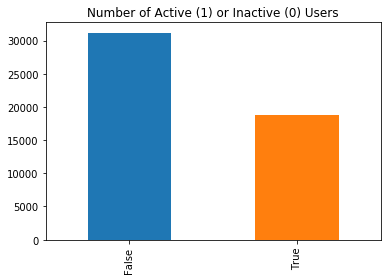

In [142]:
df1['active'].value_counts().plot(kind='bar', title='Number of Active (1) or Inactive (0) Users')

There are more inactive users than active users.

In [157]:
#The percentage of users retained:
df1['active'].sum()/len(df1)

0.37608

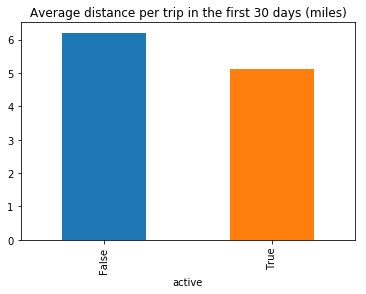

In [143]:
df1['avg_dist'].groupby(df1['active']).mean().plot(kind='bar', title='Average distance per trip in the first 30 days (miles)')

The average distance per trip in the first 30 days is longer for the inactive users than the average distance per trip for the active uses. This is very interesting. It might mean that the users taking shorter trips tend to be still active for the first 30 days. 

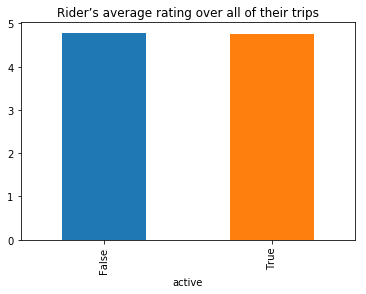

In [145]:
df1['avg_rating_by_driver'].groupby(df1['active']).mean().plot(kind='bar', title='Rider’s average rating over all of their trips')

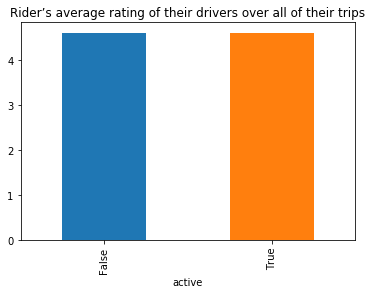

In [147]:
df1['avg_rating_of_driver'].groupby(df1['active']).mean().plot(kind='bar', title='Rider’s average rating of their drivers over all of their trips')

There is no visually difference in these ratings. If there is statistical difference, it would be very small.

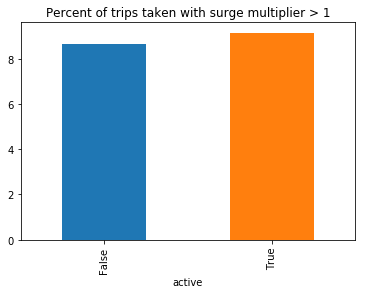

In [148]:
df1['surge_pct'].groupby(df1['active']).mean().plot(kind='bar', title='Percent of trips taken with surge multiplier > 1')

The active users have a higher average of percentage of trips taken with surge multiplier > 1. It implies that the active users needed the rides more since they are willing to take trips with a higher price, which might also be the reason why they are still active.

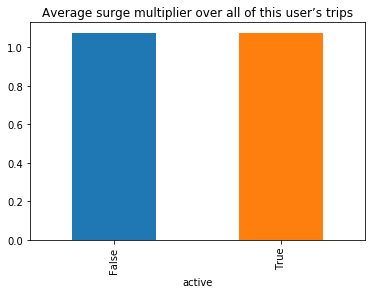

In [149]:
df1['avg_surge'].groupby(df1['active']).mean().plot(kind='bar', title='Average surge multiplier over all of this user’s trips')

The average surge multipliers over all of this user’s trips are not quite different.

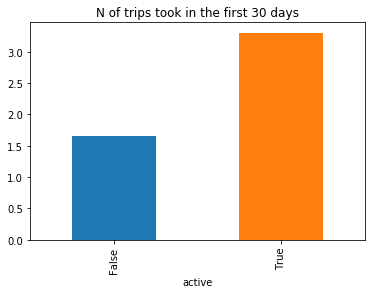

In [150]:
df1['trips_in_first_30_days'].groupby(df1['active']).mean().plot(kind='bar', title='N of trips took in the first 30 days')

The active users took significantly more trips in their first 30 days than inactive users.

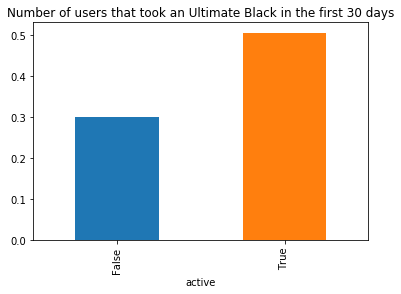

In [155]:
df1['ultimate_black_user'].groupby(df1['active']).mean().plot(kind='bar', title='Number of users that took an Ultimate Black in the first 30 days')

Here shows the percentage of users that took an ultimate Black in their first 30 days, and it is much higher for the current active users than inactive users. The reasons might be the user experience for the Ultimate Black rides make the users very happy and satisfied, so they are still using Ultimate.

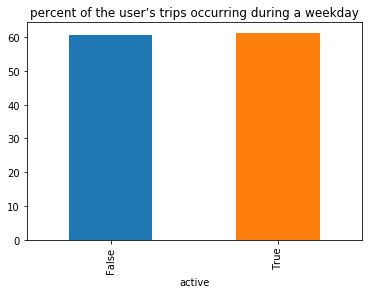

In [154]:
df1['weekday_pct'].groupby(df1['active']).mean().plot(kind='bar', title='percent of the user’s trips occurring during a weekday')

No significant difference in the user's trips occrurring during a weekday.

### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

The target variable will be the "active" column, and the predictor variables will be the rest of the columns except the last_trip_date, phone and signup_date, because all users here signed up in Jan, and the last_trip_date will be reflected in the "active" column. The phone number is irrelavant. 

In [161]:
df1 = df1.drop(columns=['last_trip_date', 'phone', 'signup_date'])

In [162]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active                    50000 non-null bool
dtypes: bool(2), float64(6), int64(1), object(1)
memory usage: 3.1+ MB


In [163]:
# There are missing values in two columns. We can use the average ratings to fill the NaNs.
df1.fillna(df1.mean(), inplace=True)

In [167]:
# Change the "city" column to categorical because it only has three values.
df1['city'] = df1['city'].astype('category')
# Change the categorical column to a numerical column
df1 = pd.get_dummies(df1, columns = ['city'] )

In [168]:
# Now all columns should be numerical columns without any missing values
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active                    50000 non-null bool
city_Astapor              50000 non-null uint8
city_King's Landing       50000 non-null uint8
city_Winterfell           50000 non-null uint8
dtypes: bool(2), float64(6), int64(1), uint8(3)
memory usage: 2.9 MB


In [169]:
X = df1.drop('active', axis=1).values
y = df1['active'].values

In [198]:
X.shape

(50000, 11)

In [181]:
# Split into training and test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

In [182]:
# Try logistic Regression
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

In [185]:
lr = LogisticRegression(solver='lbfgs', max_iter=500)

In [186]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [187]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [188]:
def print_result(clf):
    y_pred = clf.predict(X_test)
    print('The accuracy score for the train set is', clf.score(X_train, y_train))
    print('The accuracy score for the test set is', clf.score(X_test, y_test))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [189]:
print_result(lr)

The accuracy score for the train set is 0.7057
The accuracy score for the test set is 0.7007
[[5385  854]
 [2139 1622]]
              precision    recall  f1-score   support

       False       0.72      0.86      0.78      6239
        True       0.66      0.43      0.52      3761

   micro avg       0.70      0.70      0.70     10000
   macro avg       0.69      0.65      0.65     10000
weighted avg       0.69      0.70      0.68     10000



The result has an accuracy score of 0.7007 for the test set. It also showed that the precision and recall are much better for the "inactive" users than for the "active" users. 

In [191]:
# Try a random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [192]:
rf = RandomForestClassifier()

param_grid={'n_estimators':[100, 200, 300],
           'min_samples_leaf':[1,2,4], 
            'min_samples_split': [2, 5, 10]} 

estimator = GridSearchCV(rf, param_grid, cv=5)

In [193]:
estimator.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 200, 300], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [194]:
print_result(estimator)

The accuracy score for the train set is 0.86025
The accuracy score for the test set is 0.7804
[[5355  884]
 [1312 2449]]
              precision    recall  f1-score   support

       False       0.80      0.86      0.83      6239
        True       0.73      0.65      0.69      3761

   micro avg       0.78      0.78      0.78     10000
   macro avg       0.77      0.75      0.76     10000
weighted avg       0.78      0.78      0.78     10000



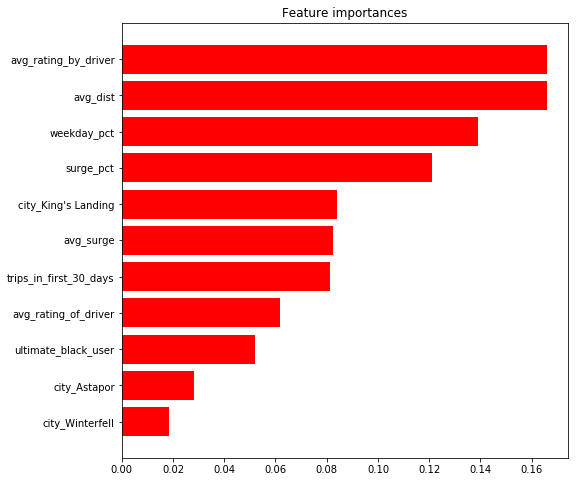

In [199]:
importances = estimator.best_estimator_.feature_importances_

indices = np.argsort(importances)

names = df1.drop(columns=['active']).columns.values

featurename = [names[i] for i in indices] 

indices = np.argsort(importances)

# Plot the feature importances with the feature names
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.barh(range(11), importances[indices][-11:],
       color="r", align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(11), featurename[-11:])
plt.ylim([-1, 11])
plt.show()

The performance by random forest is much better than logistic regression. The accuracies are higher, and the precision and recall for inactive users are much higher too.

In [201]:
# Try Gradient Boosting Machine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

In [202]:
gbc = GradientBoostingClassifier()
param_grid={'learning_rate': [0.02, 0.1, 0.2],
            'max_depth':[2, 3, 4], 
            'subsample':[0.2, 1]
           } 
estimator = RandomizedSearchCV(gbc, param_grid, cv=5)

In [203]:
estimator.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'learning_rate': [0.02, 0.1, 0.2], 'max_depth': [2, 3, 4], 'subsample': [0.2, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

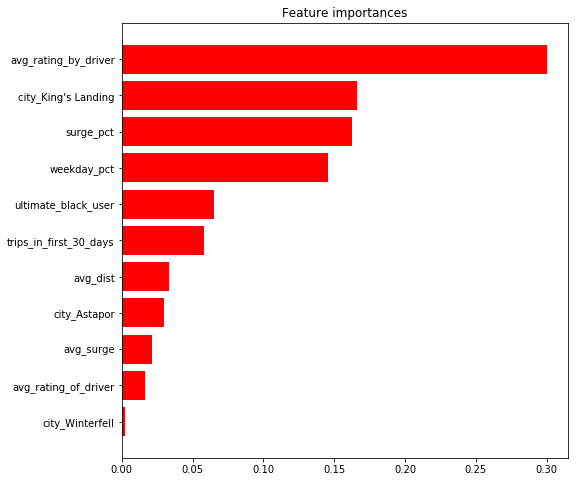

In [204]:
importances = estimator.best_estimator_.feature_importances_

indices = np.argsort(importances)

names = df1.drop(columns=['active']).columns.values

featurename = [names[i] for i in indices] 

indices = np.argsort(importances)

# Plot the feature importances with the feature names
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.barh(range(11), importances[indices][-11:],
       color="r", align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(11), featurename[-11:])
plt.ylim([-1, 11])
plt.show()

In [205]:
print_result(estimator)

The accuracy score for the train set is 0.79435
The accuracy score for the test set is 0.7835
[[5352  887]
 [1278 2483]]
              precision    recall  f1-score   support

       False       0.81      0.86      0.83      6239
        True       0.74      0.66      0.70      3761

   micro avg       0.78      0.78      0.78     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.78      0.78      0.78     10000



The accuracy score for the test set is slightly higher than that of random forest. And the precision and recall for the the inactive category are slightly higher too. So far, the gradient boosting machine is the best model to predict whether a user will be active in their 6th month.
The reason I chose RF and GBM is these are very good classifiers, they are both ensemble methods, and can greatly reduce overfitting, and they don't assume there is a linear relationship. 

The top five features given by RF are "avg_rating_by_driver", "avg_dist", "weekday_pct", "surge_pct" and "city_Kingslanding". The top five features given by GBM are "avg_rating_by_driver", "city_Kingslanding", "surge_pct", "weekday_pct", and "ultimate_black_user".

So we can see that the average rating of the rider given by drivers are the most important features, and "weekday_pct", "surge_pct", "city_Kingslanding" are important features given by both models.

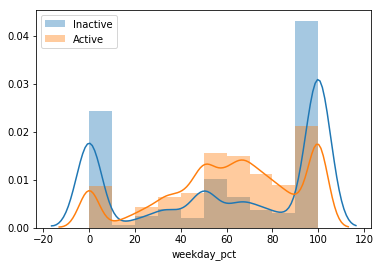

In [216]:
import seaborn as sns

sns.distplot(df1['weekday_pct'][df1['active']==False], label='Inactive', bins=10)
sns.distplot(df1['weekday_pct'][df1['active']==True], label='Active', bins=10)
plt.legend()
plt.show()

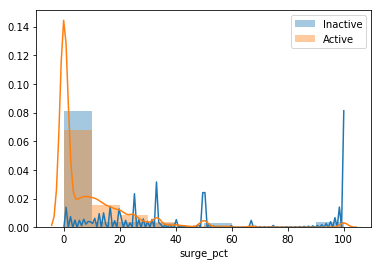

In [217]:
sns.distplot(df1['surge_pct'][df1['active']==False], label='Inactive', bins=10)
sns.distplot(df1['surge_pct'][df1['active']==True], label='Active', bins=10)
plt.legend()
plt.show()

### Insights gained from the model

1. The rider's rating is the most important feature determining whether this user will be active in 6 months. The user is likely to be retained if the drivers like him/her. The driver might rate a user high because he or she behaves politely and warmly. Although it is about basically the personality of the users, the driver's attitude might affect user's behavior too. So I would recommend all drivers and users to be polite, considerate, and friendly before they sign up and remind them frequently. This will improve the user experience of the drivers and the users, and retain users.
2. There are more users in the inactive group that had high percentage of weekday trips (90-100%). These users might use Ultimate to commute to work and home. They stop using it probably because they don't find it worth it. Ultimate can do promotions for daily commuters, so it will be cheaper for them to use Ultimate to commute and they will be more likely to retain.
3. The users for high percentage of trips taken with surge multiplier (90-100%) are now mostly inactive. If a user have to take 90-100% of their trips with a surge multiplier, they are not satisfied with the fare, and they are not likely to be active after a while. If Ultimate wants to retain these users, they should consider to change the algorithm for the surge multiplier to make the users happier about their trips. But this has to be decided after considering other factors like the drivers' willingness to drive a user at rush hour for a less surge multiplier.